# Group 1 - Model 1 - NLP Fake News Classification

**Ironhack NLP Challenge** 

Group 1 by:  Ben, Bianca, Quincy and Armando.

Model 1 by: Ben
___

Quick Overview:
- **Baseline** fake-news classifier using TF-IDF + LinearSVC, with an optional Voting (SVC+RF) ensemble
- **Method**: Train/validation split on labeled data; test file is unlabeled, so we generate predictions only (no test accuracy)
- **Evaluation**: Report accuracy, precision, recall, F1, plus a confusion matrix on the validation set.
- **Finding**: Adding Random Forest mainly shifts the precision/recall tradeoff (overall accuracy/F1 stays ~similar).
___
Files:

Model File: Model1_LinearCSV.joblib

Notebook file: model1_LinearSVC_RF.ipynb

CSV_Produced by model: Predict_LinearSCV_RF.csv
___
**Expected repo structure**
```
repo/
  data/
    training_data_lowercase.csv
    testing_data_lowercase_nolabels.csv
  code/
    model1.ipynb   (was main)
    model2.ipynb  (etc)
outputs/
  Predict_LinearSCV_RF.csv etc.
  models/
   Model1_LinearCSV.joblib etc.
```


## 1) Imports



In [1]:
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2) File paths


In [2]:
# Robust: locate the repo root by walking upward until we find a /data folder
HERE = Path(__file__).parent if "__file__" in globals() else Path.cwd()

PROJECT_ROOT = None
for p in [HERE] + list(HERE.parents):
    if (p / "data").exists():
        PROJECT_ROOT = p
        break

assert PROJECT_ROOT is not None, "Could not find repo root (a folder containing /data)."

DATA_DIR = PROJECT_ROOT / "data"

TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE  = DATA_DIR / "testing_data_lowercase_nolabels.csv"

assert TRAIN_FILE.exists(), f"Missing: {TRAIN_FILE.resolve()}"
assert TEST_FILE.exists(),  f"Missing: {TEST_FILE.resolve()}"

print("✓ Files found:", TRAIN_FILE.name, "and", TEST_FILE.name)
print("PROJECT_ROOT:", PROJECT_ROOT)


✓ Files found: training_data_lowercase.csv and testing_data_lowercase_nolabels.csv
PROJECT_ROOT: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1


> **Comments:**  
> - We load data from the repo root.


## 3) Load data



In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nTrain columns:", list(train_df.columns))
print("Test columns :", list(test_df.columns))

# train_df.head()
test_df.head()


Train shape: (34151, 1)
Test shape : (9983, 1)

Train columns: ['0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing']
Test columns : ['2\tcopycat muslim terrorist arrested with assault weapons']


,2\tcopycat muslim terrorist arrested with assault weapons
0,2\twow! chicago protester caught on camera adm...
1,2\tgermany's fdp look to fill schaeuble's big ...
2,2\tmi school sends welcome back packet warning...
3,2\tu.n. seeks 'massive' aid boost amid rohingy...
4,2\tdid oprah just leave ‚nasty‚ hillary wishin...


In [4]:
# ---- missing-value checks (top 10 columns by NA rate) ---
na_train = train_df.isna().mean().sort_values(ascending=False).head(10)
na_test = test_df.isna().mean().sort_values(ascending=False).head(10)

# print("Top NA rates (train):")
# print(na_train.__str__())

# print("\nTop NA rates (test):")
# print(na_test.__str__())

print("type(na_train):", type(na_train))
print("type(na_test) :", type(na_test))
print("na_train preview:", na_train)

type(na_train): <class 'pandas.Series'>
type(na_test) : <class 'pandas.Series'>
na_train preview: 0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing    0.0
dtype: float64


### Column names



In [5]:
import pandas as pd
from pathlib import Path

# Setup paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE = DATA_DIR / "testing_data_lowercase_nolabels.csv"

# Load data with correct delimiter (tab-separated)
train_df = pd.read_csv(TRAIN_FILE, sep='\t', header=None, names=['target', 'text'])
test_df = pd.read_csv(TEST_FILE, sep='\t', header=None, names=['target', 'text'])

# Now define your column references
TEXT_COL  = "text"
TARGET_COL = "target"

# Assertions should now pass
assert TEXT_COL in train_df.columns, f"TEXT_COL='{TEXT_COL}' not found."
assert TEXT_COL in test_df.columns, f"TEXT_COL='{TEXT_COL}' not found in test."
assert TARGET_COL in train_df.columns, f"TARGET_COL='{TARGET_COL}' not found."
assert TARGET_COL in test_df.columns, f"TARGET_COL='{TARGET_COL}' not found in test."

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# Label distribution
display(train_df[TARGET_COL].value_counts(dropna=False))


Train shape: (34152, 2)
Test shape: (9984, 2)

Train columns: ['target', 'text']
Test columns: ['target', 'text']


target
0    17572
1    16580
Name: count, dtype: int64

> **Comments:**  
> - Loaded CSV files and set column names Text & Target
> - Used the regex '\t' to separate the columns.
> - The column names are 'target' and 'text'.


## 4) Preprocessing



In [10]:
# Clean the artifacts and symbols from the dataset.

def clean_text(text: str) -> str:
    text = str(text)

    # Keep letters + whitespace (remove punctuation, digits, symbols)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Remove standalone single letters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Lowercase
    return text.lower()


In [18]:
# Apply NA handling + cleaning to the text columns
train_df[TEXT_COL] = train_df[TEXT_COL].fillna("").map(clean_text)
test_df[TEXT_COL]  = test_df[TEXT_COL].fillna("").map(clean_text)

# Target (optional label cleanup)
train_df[TARGET_COL] = train_df[TARGET_COL].astype(str).str.strip()

train_df[[TEXT_COL, TARGET_COL]].head() # Check data


,text,target
0,donald trump sends out embarrassing new year e...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama name co...,0
4,pope francis just called out donald trump duri...,0


> **Comments:**  
> - notes


## 5) Train/Validation split
We split once for fast iteration and fair model comparison.


In [11]:
X = train_df[TEXT_COL]
y = train_df[TARGET_COL]
X_test = test_df[TEXT_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (27321,) Val: (6831,)


## 6) Model
Model 1: TF‑IDF + LinearSVC - Basic


In [12]:
Model1 = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95,  sublinear_tf=True)),
    ("clf", LinearSVC(C=1.0))
]) # Ngrams with min document frequency and max doc for detecting the word patterns

t0 = time.perf_counter()
Model1.fit(X_train, y_train)
fit_s = time.perf_counter() - t0

y_pred = Model1.predict(X_val)

print("Model 1: TFIDF + LinearSVC")
print("Fit seconds:", round(fit_s, 3))
print("Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("F1 (weighted):", round(f1_score(y_val, y_pred, average="weighted"), 4))


Model 1: TFIDF + LinearSVC
Fit seconds: 0.429
Accuracy: 0.9539
F1 (weighted): 0.9539


**Comments:**

Goal: Finding an effective generalisation with linearSVC.

1st: Adjusting C regularization with LinearSVC with sunlinear_tf=False:
- 2.0 results: Fit seconds: 0.441, Accuracy: 0.9515, F1: 0.9515
- 1.0 results: Fit seconds: 0.448, Accuracy: 0.9539, F1: 0.9539
- 0.5 results: Fit seconds: 0.404, Accuracy: 0.9533, F1: 0.9533

This shows that 2.0 is too much regularization and 0.5 is not enough regularization for this dataset. Set to 1.0 even though fit time appears to take slightly longer.

Setting sunlineaer_tf=True gives a slightly better accuracy and F1 score of 0.9537, Fit seconds: 0.463, F1: 0.9537.



              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3515
           1       0.95      0.96      0.95      3316

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831



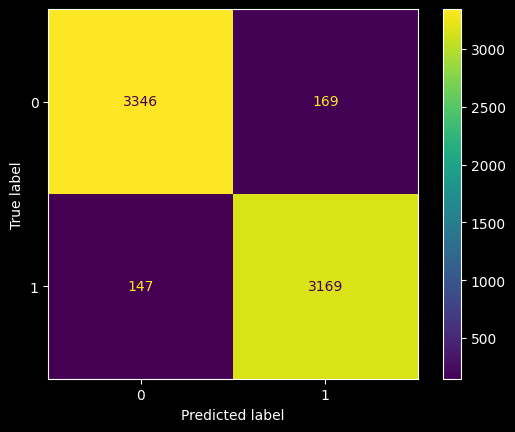

In [50]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()


 **Comments:**

Correct predictions dominate the diagonal (yellow): 3346 class 0 (fake) correctly predicted as 0, and 3169 class 1 (true) correctly predicted as 1.

Misclassifications are relatively low: 169 samples of true 0 were predicted as 1, and 147 samples of true 1 were predicted as 0.

Errors are fairly balanced across classes: the model makes a similar number of mistakes in both directions (169 vs 147), suggesting no strong bias toward one class.

Overall performance is strong: accuracy is 0.95, and both classes have F1 ≈ 0.95, meaning precision and recall are well balanced.


## 8)  Model 1 + **RandomForest** Classifier



=== Ensemble (SVC + RF) ===
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3515
           1       0.97      0.93      0.95      3316

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831



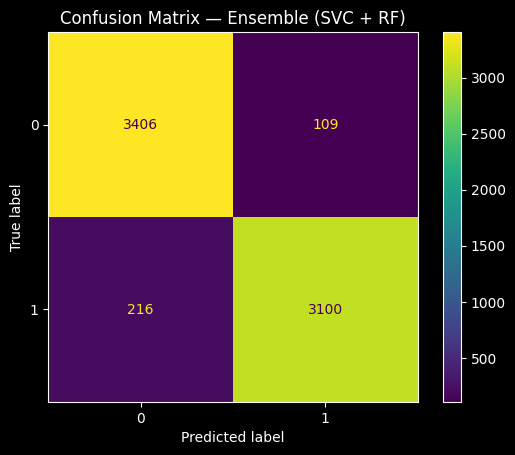

In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

ensemble_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("ensemble", VotingClassifier(
        estimators=[
            ("svc", LinearSVC(C=1.0, max_iter=2000)),
            ("rf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
        ],
        voting='hard'  # Breaks on soft voting
    ))
])

ensemble_pipe.fit(X_train, y_train)
ensemble_pred = ensemble_pipe.predict(X_val)

# Print the comparison

print("=== Ensemble (SVC + RF) ===")
print(classification_report(y_val, ensemble_pred))

labels = np.unique(y_val)
cm = confusion_matrix(y_val, ensemble_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Ensemble (SVC + RF)")
plt.show()


## 8)  Model 1: Final Evaluation

Applying RandomForest to this Model shows that recall for fake news is improved (Class: 0) from 0.94 > 0.97 but Class (1) for real names is slightly worse, 0.96 > 0.94. Showing a redistribution of class results. So better with recall but sloppier precision.

While LinearSVC is 0.96 Class 0 and 0.95 class 1 for parallel with precision and recall.

F1 stayed the same for both results.

It shows that this ensemble attempt didn't really improve the overall result and that linear SVC is best as it is with its very high and consistent scores of 0.95 overall.

**Final Notes**: (Ben) I will be looking into more data normalisation techniques (lemmatizsation/stemming) to see what effect this has and testing this model without preprocessing next.

## 11) Export model results CSV



In [59]:
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

test_pred = best_pipe.predict(X_test)  
pred_path = OUT_DIR / "Predict_LinearSCV_RF.csv"

# If your test file has an ID column, set it here. Otherwise we use row index.
ID_COL = "id" if "id" in test_df.columns else None

if ID_COL is not None:
    out_df = pd.DataFrame({ID_COL: test_df[ID_COL], TARGET_COL: test_pred})
else:
    out_df = pd.DataFrame({"id": np.arange(len(test_df)), TARGET_COL: test_pred})

out_df.to_csv(pred_path, index=False)
print("✓ Saved:", pred_path.resolve())
out_df.head()


✓ Saved: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\outputs\Predict_LinearSCV_RF.csv


,id,target
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1


## 13) Save Model

In [13]:
from pathlib import Path
import joblib

# Use the model you trained earlier
best_pipe = Model1  # Reference the pipeline from Cell #20

# Use PROJECT_ROOT (already defined in your notebook)
MODELS_DIR = PROJECT_ROOT / "Models"
MODELS_DIR.mkdir(exist_ok=True)

# Define model path clearly
model_name = "model1_LinearCSV.joblib"
model_path = MODELS_DIR / model_name

# Save the model
joblib.dump(best_pipe, model_path)

print("✓ Model saved to:", model_path.resolve())


✓ Model saved to: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\models\Model1_LinearCSV.joblib
